In [16]:
# Import necessary libraries
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [17]:

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


**Create a Custom CNN model Here i use 4 Convulation Layer with Batchnormalization use for reduce overfit one max pooling layer.. 4 Fully connected layer with Dropout for reduce overfit **

In [19]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        # Convolutional layers with increased depth and filters
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(512)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Flatten the output for fully connected layers
        x = torch.flatten(x, 1)

        # Fully connected layers with dropout and ReLU
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout3(F.relu(self.fc3(x)))
        x = self.fc4(x)

        return x


In [20]:
# Initialize model, loss function, and optimizer
net = NeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.to(device)

NeuralNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in

In [21]:
# Initialize lists to store loss, training accuracy of Custom model, and test accuracy of Custom model
train_losses_CM = []
train_accuracies_CM = []
test_accuracies_CM = []


epochs = 15
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0


    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch loss and training accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses_CM.append(epoch_loss)
    train_accuracies_CM.append(epoch_train_accuracy)



    # Print epoch loss, training accuracy, and test accuracy
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, ")


    # Save the model
    torch.save(net.state_dict(), 'net_cifar10.pth')

        # Evaluate on the test set
    net.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()


    epoch_test_accuracy = 100 * correct_test / total_test
    test_accuracies_CM.append(epoch_test_accuracy)
    print(f"Train Accuracy: {epoch_train_accuracy:.2f}%, Test Accuracy: {epoch_test_accuracy:.2f}%")


Epoch [1/15] - Loss: 1.8153, 
Train Accuracy: 28.45%, Test Accuracy: 41.84%
Epoch [2/15] - Loss: 1.4371, 
Train Accuracy: 45.88%, Test Accuracy: 56.63%
Epoch [3/15] - Loss: 1.2053, 
Train Accuracy: 57.52%, Test Accuracy: 64.61%
Epoch [4/15] - Loss: 1.0179, 
Train Accuracy: 65.58%, Test Accuracy: 70.44%
Epoch [5/15] - Loss: 0.8684, 
Train Accuracy: 71.34%, Test Accuracy: 73.24%
Epoch [6/15] - Loss: 0.7450, 
Train Accuracy: 75.57%, Test Accuracy: 74.23%
Epoch [7/15] - Loss: 0.6388, 
Train Accuracy: 79.39%, Test Accuracy: 75.23%
Epoch [8/15] - Loss: 0.5523, 
Train Accuracy: 82.58%, Test Accuracy: 76.11%
Epoch [9/15] - Loss: 0.4728, 
Train Accuracy: 85.11%, Test Accuracy: 78.46%
Epoch [10/15] - Loss: 0.4043, 
Train Accuracy: 87.47%, Test Accuracy: 78.57%
Epoch [11/15] - Loss: 0.3420, 
Train Accuracy: 89.52%, Test Accuracy: 79.78%
Epoch [12/15] - Loss: 0.2941, 
Train Accuracy: 91.09%, Test Accuracy: 81.03%
Epoch [13/15] - Loss: 0.2506, 
Train Accuracy: 92.66%, Test Accuracy: 79.80%
Epoch [1

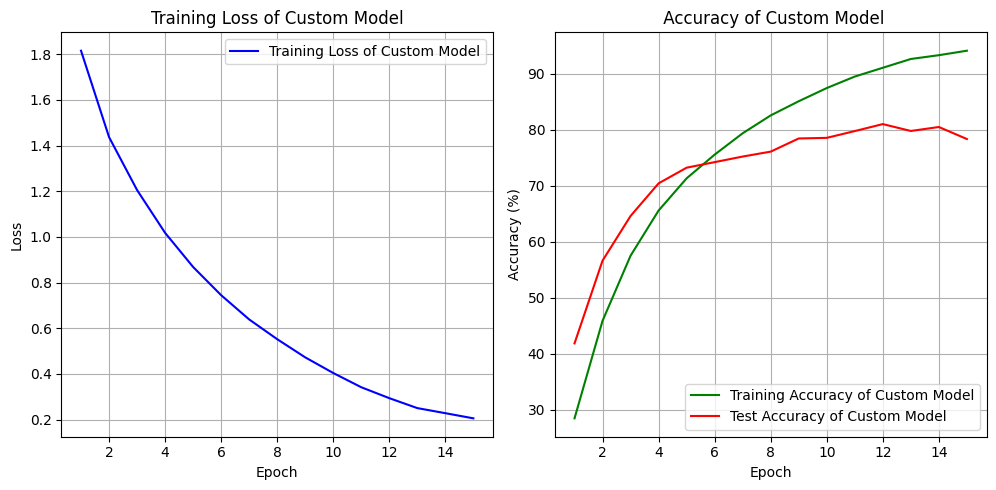

In [22]:

# Plot the training loss, training accuracy, and test accuracy
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses_CM, label='Training Loss of Custom Model', color='blue')
plt.title('Training Loss of Custom Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), train_accuracies_CM, label='Training Accuracy of Custom Model', color='green')
plt.plot(range(1, epochs + 1), test_accuracies_CM, label='Test Accuracy of Custom Model', color='red')
plt.title(' Accuracy of Custom Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()



plt.tight_layout()
plt.show()


In [23]:
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [24]:
def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image).unsqueeze(0)
    return image

In [25]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving images.jpg to images.jpg


In [26]:
# image_path = 'image.png'
image = load_image(image_path)
image = image.to(device)
net.eval()

with torch.no_grad():
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    predicted_class = class_names[predicted.item()]
    print(f"Predicted class: {predicted_class}")

Predicted class: dog



**Use of pretrain Model.. I use Resnet as pretrain model.. Change Only the output fully connect layer. for the CIFAR-10 data.. whare only 10 class in CIFAR-10 dataset **


In [27]:
from torchvision import models

# Load ResNet18 pretrained model
resnet = models.resnet18(pretrained=True)

# Modify the final layer to match CIFAR-10 (10 classes)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

# Move the model to GPU (if available)
resnet = resnet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [28]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)


In [29]:


# Initialize lists to store loss, training accuracy of Pretrain model, and test accuracy of pretrain model
train_losses_PT = []
train_accuracies_PT = []
test_accuracies_PT = []

epochs = 15
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0


    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = loss_function(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch loss and training accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses_PT.append(epoch_loss)
    train_accuracies_PT.append(epoch_train_accuracy)



    # Print epoch loss, training accuracy, and test accuracy
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, ")


    # Save the model
    torch.save(resnet.state_dict(), 'resnet_cifar10.pth')

        # Evaluate on the test set
    resnet.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_accuracy = 100 * correct_test / total_test
    test_accuracies_PT.append(epoch_test_accuracy)
    print(f"Train Accuracy: {epoch_train_accuracy:.2f}%, Test Accuracy: {epoch_test_accuracy:.2f}%")


Epoch [1/15] - Loss: 1.1146, 
Train Accuracy: 62.24%, Test Accuracy: 70.91%
Epoch [2/15] - Loss: 0.7778, 
Train Accuracy: 74.28%, Test Accuracy: 74.61%
Epoch [3/15] - Loss: 0.6449, 
Train Accuracy: 78.48%, Test Accuracy: 78.43%
Epoch [4/15] - Loss: 0.5247, 
Train Accuracy: 82.54%, Test Accuracy: 77.27%
Epoch [5/15] - Loss: 0.4173, 
Train Accuracy: 85.99%, Test Accuracy: 79.03%
Epoch [6/15] - Loss: 0.3408, 
Train Accuracy: 88.42%, Test Accuracy: 79.94%
Epoch [7/15] - Loss: 0.2736, 
Train Accuracy: 90.82%, Test Accuracy: 79.90%
Epoch [8/15] - Loss: 0.2126, 
Train Accuracy: 92.89%, Test Accuracy: 79.42%
Epoch [9/15] - Loss: 0.1720, 
Train Accuracy: 94.09%, Test Accuracy: 79.99%
Epoch [10/15] - Loss: 0.1449, 
Train Accuracy: 94.93%, Test Accuracy: 79.86%
Epoch [11/15] - Loss: 0.1252, 
Train Accuracy: 95.73%, Test Accuracy: 79.55%
Epoch [12/15] - Loss: 0.1158, 
Train Accuracy: 96.05%, Test Accuracy: 79.75%
Epoch [13/15] - Loss: 0.1041, 
Train Accuracy: 96.38%, Test Accuracy: 80.82%
Epoch [1

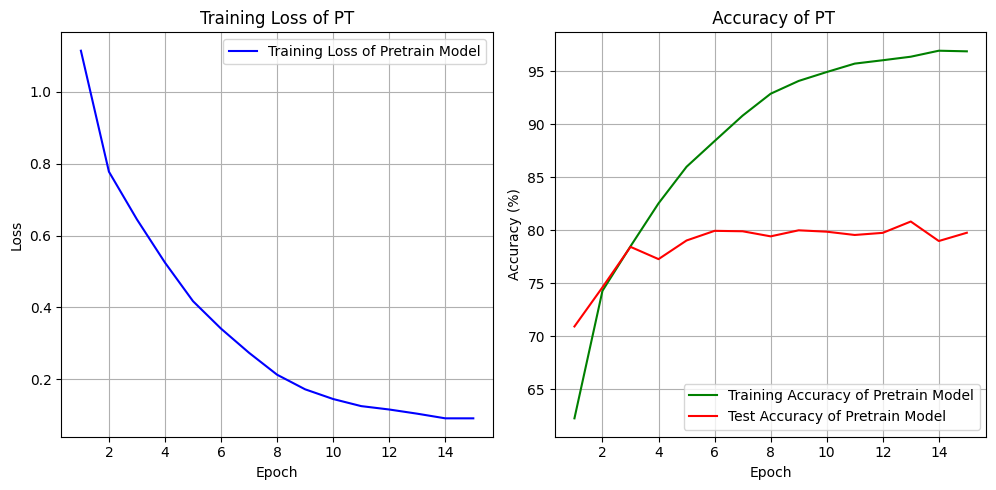

In [31]:
import matplotlib.pyplot as plt
# Plot the training loss, training accuracy, and test accuracy
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses_PT, label='Training Loss of Pretrain Model', color='blue')
plt.title('Training Loss of PT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), train_accuracies_PT, label='Training Accuracy of Pretrain Model', color='green')
plt.plot(range(1, epochs + 1), test_accuracies_PT, label='Test Accuracy of Pretrain Model', color='red')
plt.title(' Accuracy of PT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


In [32]:
# Upload image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving images.jpg to images (1).jpg


In [33]:
# Predict class of uploaded image
image = load_image(image_path).to(device)
resnet.eval()

with torch.no_grad():
    output = resnet(image)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]
    print(f"Predicted class: {predicted_class}")

Predicted class: dog


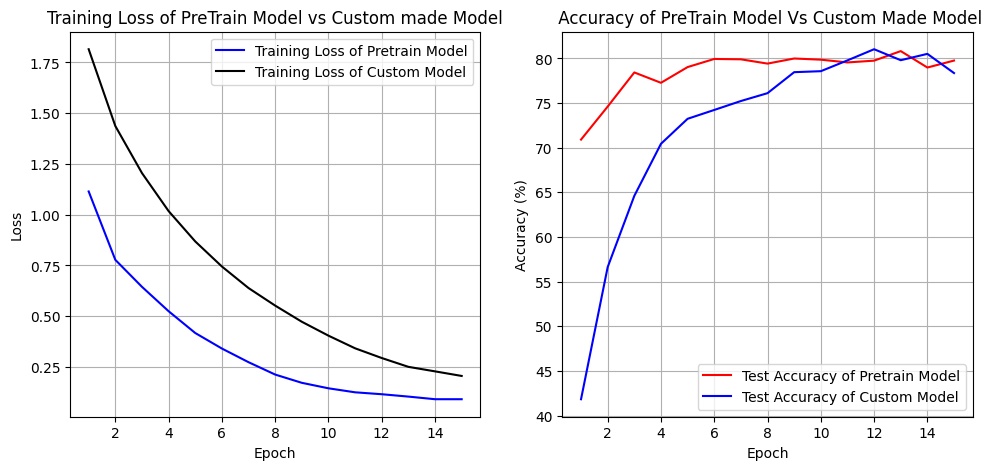

In [36]:
# Plot the training loss, training accuracy, and test accuracy
plt.figure(figsize=(18, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses_PT, label='Training Loss of Pretrain Model', color='blue')
plt.plot(range(1, epochs + 1), train_losses_CM, label='Training Loss of Custom Model', color='black')
plt.title('Training Loss of PreTrain Model vs Custom made Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
# plt.plot(range(1, epochs + 1), train_accuracies_PT, label='Training Accuracy of Pretrain Model', color='green')
plt.plot(range(1, epochs + 1), test_accuracies_PT, label='Test Accuracy of Pretrain Model', color='red')
plt.plot(range(1, epochs + 1), test_accuracies_CM, label='Test Accuracy of Custom Model',color="blue")
plt.title(' Accuracy of PreTrain Model Vs Custom Made Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()